### 3 Analysis - Plaque Density Distribution

A sliding window approach was applied on the whole slide images (WSIs) with the trained CNN model to generate confidence heatmaps. 

The WSIs were tiled into 1536 x 1536 images patches in the prepocessing steps. A sliding window approached was applied on evey image patch of a WSI. At each time, the CNN model took a 256x256 pixels region as input, forward propagated and generated a prediction score for cored plaque, diffuse plaque and CAA respectively. By systematically sliding the input region across the entire 1536 x 1536 image patch, the prediction scores were saved and ploted as prediction confidence heatmap for this patch. The heatmap for the WSI was obtained by doing this on all image patches of it.

Based on the heatmap prediction scores (saved as npy), we analyzed the plaque density distribution

In [1]:
import time, os, glob

from sklearn.cluster import KMeans
import numpy as np
import matplotlib
#matplotlib.use('PDF')   # for heatmap with original
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from tqdm import tqdm
import copy

In [2]:
IMG_DIR  = 'data/outputs/original_png/'
SAVE_DIR = 'data/outputs/heatmaps/'

filenames = glob.glob(IMG_DIR + '*.png')
filenames = [filename.split('/')[-1] for filename in filenames]
print(filenames)

['NA3777-02_AB.png', 'NA4077-02_AB.png', 'NA4092-02_AB.png', 'NA4107-02_AB.png', 'NA4160-02_AB.png', 'NA4195-02_AB.png', 'NA4256-02_AB.png', 'NA4299-02_AB.png', 'NA4391-02_AB.png', 'NA4450-02_AB.png', 'NA4463-02_AB.png', 'NA4471-02_AB.png', 'NA4553-02_AB.png', 'NA4626-02_AB.png', 'NA4672-02_AB.png', 'NA4675-02_AB.png', 'NA4691-02_AB.png', 'NA4695-02_AB.png']


In [3]:
# Load normalized original WSI
t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
    if i != 0:
        continue
    
    img = np.array(Image.open(IMG_DIR+filename))
    assert(img.dtype == 'uint8')
    height, width, _ = img.shape
    
    t.set_description_str("Image " + str(i) + ': ' + str(img.shape))
    t.refresh()
    t.write("", end=' ')
    

    
    t.update()
t.close()

Image 0: (47616, 55296, 3):   6%|▌         | 1/18 [01:16<21:36, 76.26s/it]

In [30]:
a = np.where(np.all(img <= [70, 77, 85], axis=-1))

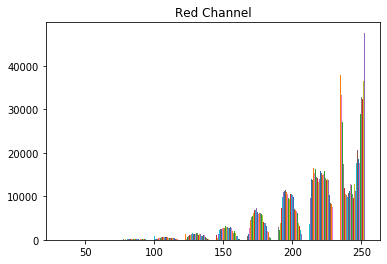

[0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3]
[1885 1886 1888 1889 1890 1891 1892 1885 1886 1888 1889 1890 1891 1885
 1886 1888 1889 1890 1891 1883]
[70 77 85]


In [32]:
plt.hist(img[:,:,0], 20)
plt.title('Red Channel')
plt.show()


print(a[0][0:20])
print(a[1][0:20])
print(img[929, 40021])
# print(a[0][np.where(a[1]==830)])
# print(a[1][np.where(a[1]==830)])

In [3]:
from skimage import data
from skimage.color import rgb2hsv
rgb_img = np.array(Image.open('data/outputs/original_png/NA3777-02_AB.png'))
hsv_img = Image.fromarray(rgb2hsv(rgb_img), 'HSV')
hsv_img.save('data/outputs/original_png/NA3777-02_AB_HSV.png')

MemoryError: 

In [6]:
red = img[:,:,0]
mask_r = np.full(red.shape, 255, dtype=np.uint8)
mask_r[(red > 73) & (red < 231)] = 0

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, title='Red')
im = plt.imshow(mask_r, cmap=plt.cm.get_cmap('Greys', 20), vmin=0, vmax=255)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
plt.show()

MemoryError: 

<Figure size 1080x1080 with 2 Axes>

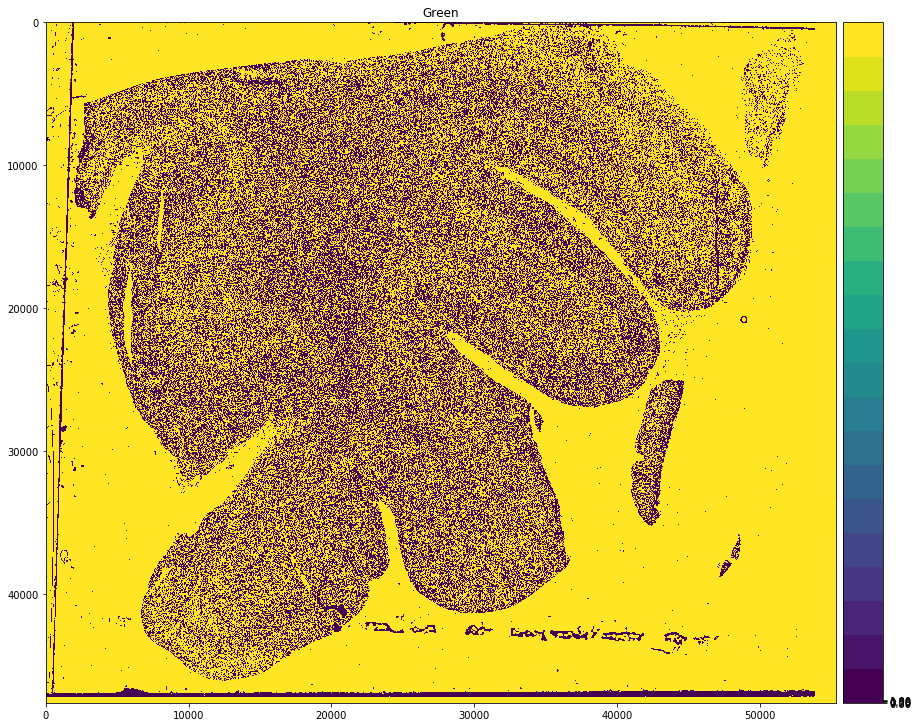

In [5]:
green = img[:,:,1]
mask_g = np.full(green.shape, 255, dtype=np.uint8)
mask_g[(green > 80) & (green < 200)] = 0

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, title='Green')
im = plt.imshow(mask_g, cmap=plt.cm.get_cmap('Greys', 20), vmin=0, vmax=255)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
plt.show()

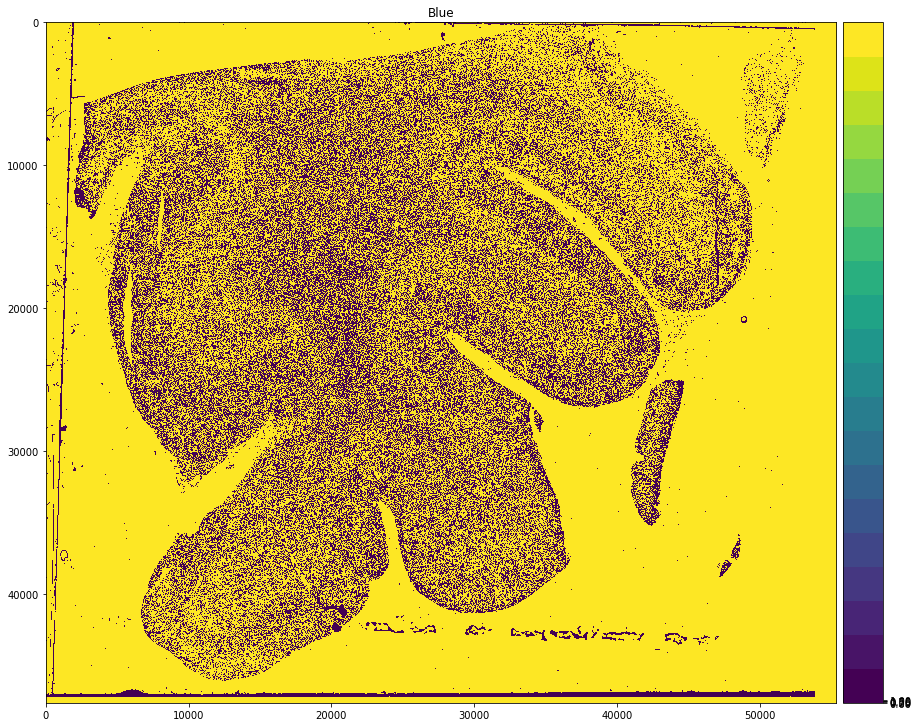

In [6]:
blue = img[:,:,2]
mask_b = np.full(blue.shape, 255, dtype=np.uint8)
mask_b[(blue > 80) & (blue < 200)] = 0

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, title='Blue')
im = plt.imshow(mask_b, cmap=plt.cm.get_cmap('Greys', 20), vmin=0, vmax=255)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
plt.show()

In [34]:
heatmaps = np.load('data/outputs/heatmaps/'+'NA3777-02_AB.npy')

In [36]:
heatmaps.shape

(3, 2976, 3456)